In [4]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Now using device: {device}")

Now using device: cuda


In [2]:
#load dataset
dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

100%|██████████| 9.91M/9.91M [00:37<00:00, 264kB/s] 
100%|██████████| 28.9k/28.9k [00:07<00:00, 4.05kB/s]
100%|██████████| 1.65M/1.65M [00:57<00:00, 28.5kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.73MB/s]


In [3]:
#use DataLoader
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([0, 9, 1, 3, 4, 2, 3, 1])


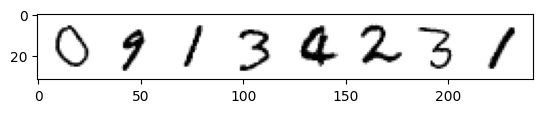

In [5]:
#take a look 
x, y =next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

In [ ]:
#noise to corrupt image
def corrupt(x, amount):
    # corrupt the input x by mixing with noise according to amount
    
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1) #sort shape to braodcast
    
    #amount is continuous from 0 to 1, 0 is no noise (original image), 1 is total corruption
    return x * (1 - amount) + noise * amount

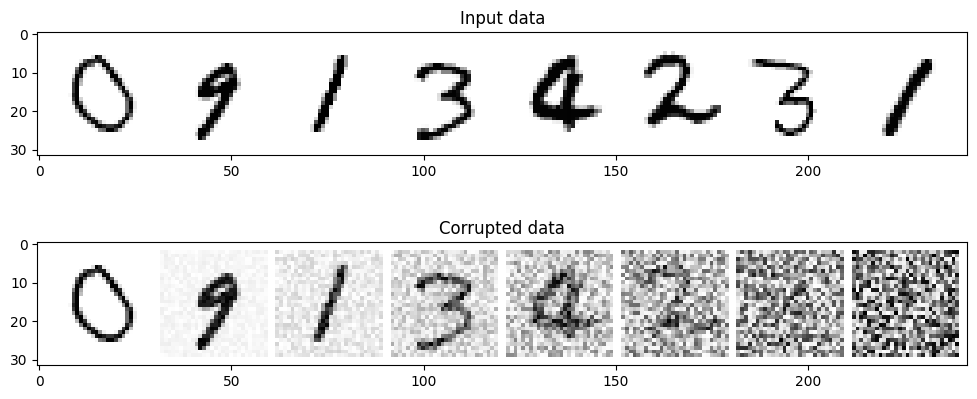

In [10]:
# to see coruption process
# plot data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

#add noise
amount = torch.linspace(0, 1, x.shape[0]) #left to right as corruption increases
noised_x = corrupt(x, amount)

#plot the noised data
axs[1].set_title("Corrupted data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")


In [13]:
# Model Architecture (U-Net)

#by pytorch for simplicity
class BasicUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        self.down_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
            ]
        )

        self.up_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
            ]
        )

        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
          
        h = [] # for skip connection use

        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) #pass through the layer then SiLU activation

            if i < 2: # downscaling for all layer except the final layer
                h.append(x) # store output for skip connection 
                x = self.downscale(x) #ready for next layer

        for i, l in enumerate(self.up_layers):
            if i > 0: #upscale all layer except for the first layer
                x = self.upscale(x)
                x += h.pop() #fetch from stored output at the down layers
            
            x = self.act(l(x))

        return x
     



In [14]:
#verify shape
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

In [15]:
#check parameter amount
sum([p.numel() for p in net.parameters()])

309057

In [ ]:
#batch distribution
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

n_epochs = 3

#instantiate model
net = BasicUNet()
net.to(device)

#loss
loss_fn = nn.MSELoss()

#optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

#keep record of loss
losses = []


In [ ]:
#training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        x = x.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device) #random amount of noise
        noisy_x = corrupt(x, noise_amount)

        pred = net(noisy_x)
        loss = loss_fn(pred, x)

        #backpropogation
        opt.zero_grad()
        loss.backward()
        opt.step()

        #store loss
        losses.append(loss.item())
    
    #avg loss per epoch
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

#view loss curve
plt.plot(losses)
plt.ylim(0, 0.1)

Finished epoch [tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 

KeyboardInterrupt: 

In [ ]:
#see the model prediction
x, y = next(iter(train_dataloader))
x = x[:8]

#corruption
amount= torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

#predictions
with torch.no_grad():
    preds = net(noised_x.to(device).detach().cpu())

#plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Corrupted data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap="Greys")
axs[2].set_title("Network Predictions")
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap="Greys")


In [ ]:
#break the process into 5 steps denoising process
n_steps = 5
x= torch.rand(8, 1, 28, 28).to(device) #from random
step_history = [x.detach().cpu()]
pred_output_history = []

#denoising loop
for i in range(n_steps):

    with torch.no_grad():
        pred = net(x)

    pred_output_history.append(pred.detach().cpu())
    mix_factor = 1 / (n_steps - i) #this term should increase over step
    x = x * (1 - mix_factor) + pred * mix_factor #increasing mix_factor will make pred stronger over time
    step_history.append(x.detach().cpu())

#plotting results
fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title("x (model input)")
axs[0, 1].set_title("model prediction")

for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys")
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap="Greys")

In [ ]:
#more steps (40)

n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (1 - (i / n_steps)) # from high to low

    with torch.no_grad():
        pred = net(X)

    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap="Greys")
